Signalų paruošimas 

# 1. Katės ir šuns signalų apjungimas į vieną ir atskyrimas

Pirmiausia suvienodinami signalų ilgiai, kad jie turėtų 2^n reikšmes ir pakomponenčiui yra sujungiami. 

In [91]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, ifft ############# Veliau naudoti tik savo sukurta FFT ir inverse FFT. !!!!!
import numpy as np
import wave, struct, math, random
import numpy as np
import pandas as pd


In [35]:
rate1, dog_data = wav.read('dog_barking_91.wav')
rate2, cat_data = wav.read('cat_152.wav')

Toliau pasižiūrime pagrindinius signalų parametrus

In [37]:
obj = wave.open('dog_barking_91.wav','r')
print ( "Dog parameters:",obj.getparams())
obj.close()
obj = wave.open('cat_152.wav','r')
print ( "Cat parameters:",obj.getparams())
obj.close()

Dog parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=192000, comptype='NONE', compname='not compressed')
Cat parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=188800, comptype='NONE', compname='not compressed')


Pasižiūrime, ar listo ilgis yra $2^n$, jei ne, pasirenkame artimiausią reikšmę ir pridedame reikiamą kiekį nulių į listą

In [59]:
def ar_2n(listo_ilgis):
    for i in range(1, listo_ilgis):
        if 2 ** i >= listo_ilgis:
            tinkamas_ilgis = 2 ** i
            return tinkamas_ilgis

In [63]:
print(ar_2n(len(dog_data)))
print(ar_2n(len(cat_data)))

262144
262144


Mateome, kad abu listus reikia prailginti iki 262144 reikšmių. Pridedame atitinkamą skaičių nulių

In [65]:
dog_data = np.pad(dog_data, (0, ar_2n(len(dog_data)) - len(dog_data)), 'constant')

In [68]:
cat_data = np.pad(cat_data, (0, ar_2n(len(cat_data)) - len(cat_data)), 'constant')

Signalų komponentes sudedame ir įrašome atgal į .wav failą.

In [71]:
cat_dog_data = dog_data + cat_data

Įrašome naują katės ir šuns signalą

In [75]:
obj = wave.open('cat_dog.wav','w')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(16000)
for i in range(len(cat_dog_data)):
   value = int(cat_dog_data[i].real)
   data = struct.pack('<h', value)
   obj.writeframesraw( data )
obj.close()

Nuskaitome signalą. Išlaikyti simetriją. Keičiant ck, pakeisti ir cN-k

In [506]:
rate_cd, cd_data = wav.read('cat_dog.wav')


Randame signalo trukmę sekundėmis (duration is equal to the number of frames divided by the framerate (frames per second))

In [507]:
trukme = wave.open('cat_dog.wav','r')
trukme = trukme.getnframes() / trukme.getframerate()
trukme

16.384

Pagal internete rastą informaciją (https://www.answers.com/Q/How_many_Hz_is_a_dog_bark), šuns lojimas gali būti nuo 160 Hz iki 2630 Hz, priklausomai nuo to, dėl ko šuo loja. Todėl norint atskirti katės balsą nuo šuns, visas reikšmes iki 2000 Hz užnulinsime. 

Funkcija braižanti galios spektrą pagal signalo fft ir trukmę

In [831]:
def galios_spektras(fftr, trukme):
    ckpow_reiksmes = abs(fftr)**2
    N = len(ckpow_reiksmes)
    Hercai = []
    for k in range(0, N):
        hercas = k/trukme
        Hercai.append(hercas)
    puse_hercu = Hercai[0:N//2] 
    ckpow_reiksmes_puse = ckpow_reiksmes[0:N//2]

    plt.plot(puse_hercu, ckpow_reiksmes_puse, c='black')
    plt.xlabel('Hz',fontsize = 15)
    plt.ylabel('$|c_k|^2$', fontsize = 15)
    plt.xlim(50, 250)
    plt.savefig('pastumtasManoUznulintas.png', bbox_inches='tight', dpi=300 )
    return plt.show()

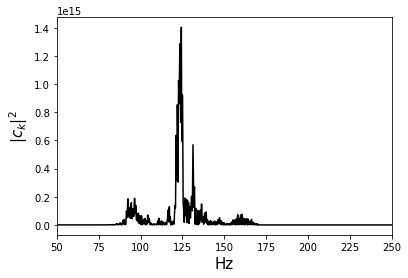

In [832]:
galios_spektras(uznulintas, trukme)

In [508]:
def uznulinti_Hz_intervale(fft_reiksmes, NulintinuoHz, nulintiikiHz): # funkcija, kuri uznulina fft reiksmes simetriskai pagal hercu intervala

    N = len(fft_reiksmes)
    Hercai = []
    Hercu_indeksai = []
    for k in range(0, N):
        hercas = k/trukme
        Hercai.append(hercas)
    HercaiA = np.array(Hercai)
    list_of_tuples = list(zip(Hercai, fft_reiksmes))
    df = pd.DataFrame(list_of_tuples,
                      columns = ['Hz', 'fft_reiksmes'])
    nuliai = np.where(df['fft_reiksmes'] == 0)
    if len(nuliai[0]) == 0:
        
        df['fft_reiksmes'] = np.where(df['Hz'].between(NulintinuoHz,nulintiikiHz), 0, df['fft_reiksmes'])
        nuliai1 = np.where(df['fft_reiksmes'] == 0)
        df.loc[(len(fft_reiksmes)-len(nuliai1[0])):len(fft_reiksmes),'fft_reiksmes'] = 0
        my_array = df['fft_reiksmes'].to_numpy()
        
        return my_array
    else:
        return print('Error')

In [519]:
uznulinti_ck = uznulinti_Hz_intervale(fft(cd_data),1000,8000)
uznulinti_ck

array([-1666758.             -0.j        ,
         459192.8803324 +239807.34595715j,
         181140.64160312+269380.96889476j, ...,
              0.             +0.j        ,
              0.             +0.j        ,
              0.             +0.j        ])

In [520]:
nen = uznulinti_ck
nen = ifft(nen)
nen = nen.real.astype('int16')

In [521]:
obj = wave.open('only_dog1000.wav','wb')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(16000)
for i in range(len(nen)):
   value = nen[i]
   data = struct.pack('<h', value)
   obj.writeframesraw( data )
obj.close()

only_dog - tiesiog tylesnis garsas, kai buvo auksti dazniai uznulinti

only_cat - pavyko gana gerai panaikinti suns lojima. 

# Katės pavertimas šunimi, šuns pavertimas kate
Reiksmiu pastumimas per tam tikra Hercu kieki i kaire arba i desine

In [749]:
s = wave.open('cat_data2pow.wav','r')
trukme = s.getnframes() / s.getframerate()
trukme

16.384

In [750]:
len(cat_data)

262144

In [758]:
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [752]:
fft_cat = fft(cat_data)
fft_dog = fft(dog_data)

In [754]:
postumio_dydis_hz = np.where(puse_hercu == 110)
postumis = postumio_dydis_hz[0]
postumis
sift_i_desine = shift(fft_cat_puse , 32768)
sift_i_desine[np.isnan(sift_i_desine)] = 0
sift_i_desine
sift_i_kaire = shift(kita_fft_cat_puse , -32768)
sift_i_kaire[np.isnan(sift_i_kaire)] = 0
sift_i_kaire
patumtas = np.concatenate((sift_i_desine, sift_i_kaire), axis=None)

array([32768], dtype=int64)

In [594]:
nen = patumtas
nen = ifft(nen)
nen = nen.real.astype('int16')

In [595]:
obj = wave.open('pastumtasDog2000Hz.wav','wb')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(16000)
for i in range(len(nen)):
   value = nen[i]
   data = struct.pack('<h', value)
   obj.writeframesraw( data )
obj.close()

In [533]:
N = len(fft_cat)

In [534]:
Hercai = []

for k in range(0, N):
    hercas = k/trukme
    Hercai.append(hercas)
HercaiA = np.array(Hercai)

In [550]:
puse_hercu = HercaiA[0:N//2] 
fft_cat_puse = fft_cat[0:N//2]

In [549]:
kita_puse_hercu = HercaiA[N//2:N] 
kita_fft_cat_puse = fft_cat[N//2:N]

In [579]:
fft_dog_puse = fft_dog[0:N//2]

In [580]:
kita_fft_dog_puse = fft_dog[N//2:N]

# Mano balsas. I vyriska

In [762]:
rate, mano_balsas = wav.read('laba_diena.wav')
s = wave.open('laba_diena2pow.wav','r')
ar_2n(len(mano_balsas))


262144

In [769]:
mano_balsas = np.pad(mano_balsas, (0, ar_2n(len(mano_balsas)) - len(mano_balsas)), 'constant')
N=len(mano_balsas)
N

262144

In [764]:
obj = wave.open('laba_diena2pow.wav','wb')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(48000)
for i in range(len(mano_balsas)):
   value = mano_balsas[i]
   data = struct.pack('<h', value)
   obj.writeframesraw( data )
obj.close()

In [799]:
trukme = s.getnframes() / s.getframerate()
trukme

5.461333333333333

In [800]:
fft_mano = fft(mano_balsas)


In [801]:
postumio_dydis_hz = np.where(puse_hercu == 110.04638671875)
postumis = postumio_dydis_hz[0]
postumis


array([601], dtype=int64)

In [802]:
Hercai = []

for k in range(0, N):
    hercas = k/trukme
    Hercai.append(hercas)
HercaiA = np.array(Hercai)

In [780]:
for i in puse_hercu:
    print(i)

0.0
0.18310546875
0.3662109375
0.54931640625
0.732421875
0.91552734375
1.0986328125
1.28173828125
1.46484375
1.64794921875
1.8310546875
2.01416015625
2.197265625
2.38037109375
2.5634765625
2.74658203125
2.9296875
3.11279296875
3.2958984375
3.47900390625
3.662109375
3.84521484375
4.0283203125
4.21142578125
4.39453125
4.57763671875
4.7607421875
4.94384765625
5.126953125
5.31005859375
5.4931640625
5.67626953125
5.859375
6.04248046875
6.2255859375
6.40869140625
6.591796875
6.77490234375
6.9580078125
7.14111328125
7.32421875
7.50732421875
7.6904296875
7.87353515625
8.056640625
8.23974609375
8.4228515625
8.60595703125
8.7890625
8.97216796875
9.1552734375
9.33837890625
9.521484375
9.70458984375
9.8876953125
10.07080078125
10.25390625
10.43701171875
10.6201171875
10.80322265625
10.986328125
11.16943359375
11.3525390625
11.53564453125
11.71875
11.90185546875
12.0849609375
12.26806640625
12.451171875
12.63427734375
12.8173828125
13.00048828125
13.18359375
13.36669921875
13.5498046875
13.73291015

In [803]:
puse_hercu = HercaiA[0:N//2] 
fft_mano_puse = fft_mano[0:N//2]

In [804]:
kita_puse_hercu = HercaiA[N//2:N] 
kita_fft_mano_puse = fft_mano[N//2:N]

In [805]:
sift_i_desine = shift(fft_mano_puse , -601)
sift_i_desine[np.isnan(sift_i_desine)] = 0
sift_i_desine
sift_i_kaire = shift(kita_fft_mano_puse , 601)
sift_i_kaire[np.isnan(sift_i_kaire)] = 0
sift_i_kaire
patumtas = np.concatenate((sift_i_desine, sift_i_kaire), axis=None)

In [833]:
nen = uznulintas
nen = ifft(nen)
nen = nen.real.astype('int16')

In [834]:
obj = wave.open('labadienaVyr110nulintas.wav','wb')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(48000)
for i in range(len(nen)):
   value = nen[i]
   data = struct.pack('<h', value)
   obj.writeframesraw( data )
obj.close()

In [827]:
uznulintas = uznulinti_Hz_intervale(patumtas, 170, 25000)

In [823]:
patumtas = np.where(patumtas == 0, 1, patumtas)

# Vidurkinimas

In [739]:
s = wave.open('Heart_beatpow2.wav','r')
trukme = s.getnframes() / s.getframerate()
trukme

11.888616780045352

In [748]:
rate, sirdis = wav.read('Heart_beat.wav')
s = wave.open('Heart_beat.wav','r')
#ar_2n(len(sirdis))
s.getframerate()
s.close()

Signalui reikia pridėti atitinkamą skaičių nulių, kad būtų galima atlikti FFT 

In [737]:
sirdis = np.pad(sirdis, (0, ar_2n(len(sirdis)) - len(sirdis)), 'constant')
N= len(sirdis)

In [711]:
fft_sirdis = fft(sirdis)
fft_sirdis

array([-1.00000000e+02     -0.j        ,  6.30189427e+05+192596.13404223j,
        4.53690852e+05 -45034.48793501j, ...,
        3.82379477e+05  +9759.50412961j,  4.53690852e+05 +45034.48793501j,
        6.30189427e+05-192596.13404223j])

In [835]:
def slenkantis_vidurkis(reiksmes, poslinkis):
    return np.convolve(reiksmes, np.ones(poslinkis), 'valid') / poslinkis

In [719]:
move2puse =(slenkantis_vidurkis(sirdis_puse2, 20))

In [718]:
sirdis_puse = fft_sirdis[0:N//2]
sirdis_puse2 = fft_sirdis[N//2:N]

In [728]:
sirdis_puseMov = np.pad(move1puse, (0, (len(sirdis_puse)) - len(move1puse)), 'constant')

In [729]:
move2pusejoin = sirdis_puseMov[::-1]

In [ ]:
sirdis_puseMov2 = np.pad(move1puse, (0, (len(sirdis_puse)) - len(move1puse)), 'constant')

In [730]:
vidurkis = np.concatenate((sirdis_puseMov, move2pusejoin), axis=None)

In [732]:
nen = vidurkis
nen = ifft(nen)
nen = nen.real.astype('int16')

In [738]:
obj = wave.open('Heart_beatpow2.wav','wb')
obj.setnchannels(1)
obj.setsampwidth(2)
obj.setframerate(11025)
for i in range(len(sirdis)):
   value = sirdis[i]
   data = struct.pack('<h', value)
   obj.writeframesraw( data )
obj.close()

In [653]:
def mano_FFT(f_reiksmes, atvirkstine = False):
    N = len(f_reiksmes)
    if N == 1:
        return f_reiksmes
    W = np.exp((1j if atvirkstine else -1j)*2*np.pi/N)

    f_reiksmes_lygines = f_reiksmes[::2]
    f_reiksmes_nelygines = f_reiksmes[1::2]

    # vykdoma rekursija vis iskvieciant funkcija viduje 
    ck_lyginiai = mano_FFT(f_reiksmes_lygines)
    ck_nelyginiai = mano_FFT(f_reiksmes_nelygines)

    c = np.zeros(N,dtype=np.complex_) 
    for k in range(N//2):
        c[k] = (ck_lyginiai[k] + W ** k * ck_nelyginiai[k])/(N if atvirkstine else 1)
        c[k + N//2] = (ck_lyginiai[k] - (W**k) * ck_nelyginiai[k])/(N if atvirkstine else 1)

    return c

In [655]:
fft_mano_balsasM = mano_FFT(mano_balsas)

In [837]:
def mano_DFT(f, atvirkstine=False):
    ck_reiksmes = []
    N = len(f)
    for j in range(0,N):
        sum = 0
        for k in range(0,N):
            sum += f[k] * math.e ** ((1j if atvirkstine else -1j) *(2 * math.pi/N) * j * k)
        ck_reiksmes.append(sum/(N if atvirkstine else 1))
    return ck_reiksmes

In [844]:
def mano_FFT(f_reiksmes, atvirkstine=False):
    N = len(f_reiksmes)
    if N == 1:
        return f_reiksmes
    W = np.exp((1j if atvirkstine else -1j)*2*np.pi/(N))*(1/N if atvirkstine else 1)

    f_reiksmes_lygines = f_reiksmes[::2]
    f_reiksmes_nelygines = f_reiksmes[1::2]

    # vykdoma rekursija vis iskvieciant funkcija viduje 
    ck_lyginiai = mano_FFT(f_reiksmes_lygines)
    ck_nelyginiai = mano_FFT(f_reiksmes_nelygines)

    c = np.zeros(N, dtype=np.complex_) 
    for k in range(N//2):
        c[k] = (ck_lyginiai[k] + W ** k * ck_nelyginiai[k])
        c[k + N//2] = (ck_lyginiai[k] - (W**k) * ck_nelyginiai[k])
    return c

DFT ir FFT palyginimas 

In [838]:
f_reiksmes = np.array(range(0,8))

In [839]:
dft = mano_DFT(f_reiksmes)
dft

[(28+0j),
 (-4.0000000000000036+9.65685424949238j),
 (-4.000000000000002+3.9999999999999987j),
 (-4.000000000000001+1.656854249492385j),
 (-4-3.4290110376125885e-15j),
 (-4.000000000000009-1.6568542494923895j),
 (-4.000000000000015-4.000000000000005j),
 (-3.999999999999977-9.656854249492369j)]

In [845]:
fft = mano_FFT(f_reiksmes)
fft

array([28.+0.j        , -4.+9.65685425j, -4.+4.j        , -4.+1.65685425j,
       -4.+0.j        , -4.-1.65685425j, -4.-4.j        , -4.-9.65685425j])

In [842]:
idft = mano_DFT(dft, atvirkstine=True)
idft

[(-9.992007221626409e-16-6.661338147750939e-16j),
 (1.0000000000000016+1.887379141862766e-15j),
 (2.0000000000000053-3.7192471324942744e-15j),
 (2.999999999999998-3.9968028886505635e-15j),
 (3.999999999999997-2.220446049250313e-15j),
 (5.000000000000001+1.2212453270876722e-15j),
 (6.000000000000001+5.495603971894525e-15j),
 (6.999999999999998-1.7763568394002505e-15j)]

In [846]:
ifft = mano_FFT(fft, atvirkstine=True)
ifft

array([ 0.  -8.88178420e-16j, 40.  +2.00000000e+00j,
       31.75-1.38777878e-17j, 24.  -3.12500000e-02j,
       32.  +8.88178420e-16j, 40.  -2.00000000e+00j,
       32.25+1.38777878e-17j, 24.  +3.12500000e-02j])

In [697]:
%timeit  mano_FFT(f_reiksmes)
%timeit  mano_DFT(f_reiksmes)


227 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6min 49s ± 1min 46s per loop (mean ± std. dev. of 7 runs, 1 loop each)
